In [9]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Uniform
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import Left, Interval
import datetime

# Helpers

In [26]:
noise_lambda = lambda metric: list(itertools.chain(*[[results[results['var'] == v][metric].idxmax(), results[results['var'] == v][metric].idxmin()] for v in range(1, 10)]))

In [33]:
STORE_PATH = '/home/pstefanou/Uniform2'
STORE_TABLE_NAME = 'noshuffle'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float,
    'unknown_var_mse': float,
    'ols_param_mse': float,
    'ols_var_mse': float,
    'alpha': float, 
    'var': float, 
})

Logging in: /home/pstefanou/Uniform2/babb1017-8343-4062-9f5c-d82e3bdffcbc


In [44]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 10
PREDICATE = Left(Tensor([1.0]))
LOWER, UPPER = -1, 1
# experiment parameters
args = Parameters({ 
    'phi': PREDICATE, 
    'epochs': 10,
    'num_workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': True, 
    'tol': 5e-2,
})

In [ ]:
# perform each experiment a total of 10 times
for iter_ in range(10):        
    for var in range(1, 10):
        # generate synthetic data until reasonable survival prob
        ALPHA = None 
        while ALPHA is None or ALPHA < .5:
            # generate random uniform weights
            W = Uniform(LOWER, UPPER).sample(ch.Size([DIMS, 1]))
            W0 = Uniform(LOWER, UPPER).sample(ch.Size([1, 1]))
            
            if ALPHA is not None: 
                print("regenerate rergression...")
            # generate data
            X = Uniform(0, 1).sample(ch.Size([NUM_SAMPLES, DIMS]))
            y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([NUM_SAMPLES]))
            # truncate
            indices = PREDICATE(y).nonzero(as_tuple=False).flatten()
            y_trunc, x_trunc = y[indices], X[indices]

            # empirical linear regression
            OLS = LinearRegression() 
            OLS.fit(x_trunc, y_trunc)
            OLS_VAR = ch.var(ch.from_numpy(OLS.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)
            # empirical varince
            args.__setattr__('ols_var', OLS_VAR)
            ALPHA = Tensor([y_trunc.size(0)/NUM_SAMPLES])
            # set survival probability
            args.__setattr__('alpha', ALPHA)

        # truncated linear regression with known noise variance
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=args.phi, alpha=args.alpha, epochs=args.epochs, lr=args.lr, num_samples=args.num_samples, var=args.ols_var, tol=args.tol)
        results = trunc_reg.fit(S)
        w_, w0_ = results.weight.detach().cpu(), results.bias.detach().cpu()

        # truncated linear regression with unknown noise variance
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=args.phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, tol=args.tol)

        results = trunc_reg.fit(S)
        var_ = results.lambda_.inverse().detach().cpu()
        w, w0 = (results.v.detach()*var_).cpu(), (results.bias.detach()*var_).cpu()

        # parameter estimates 
        real_params = ch.cat([W, W0])
        ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
        unknown_params = ch.cat([w, w0])
        known_params = ch.cat([w_.T, w0_.unsqueeze(0)])
        
        # metrics
        unknown_param_mse = mean_squared_error(unknown_params, real_params)
        unknown_var_mse = mean_squared_error(var_, Tensor([var]))
        ols_param_mse = mean_squared_error(ols_params, real_params)
        ols_var_mse = mean_squared_error(args.ols_var, Tensor([var]))
        known_param_mse = mean_squared_error(known_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'known_param_mse': known_param_mse,
            'unknown_param_mse': unknown_param_mse,
            'unknown_var_mse': unknown_var_mse,
            'ols_param_mse': ols_param_mse,
            'ols_var_mse': ols_var_mse,
            'alpha': float(args.alpha.flatten()),
            'var': float(var), 
        })

# close current store
store.close()

# Read Experiment Results

In [36]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
reader.close()
results.head()

100%|██████████| 3/3 [00:00<00:00, 221.70it/s]

,known_param_mse,unknown_param_mse,unknown_var_mse,ols_param_mse,ols_var_mse,alpha,var,exp_id
0,0.258328,0.258854,0.511554,0.266347,0.510424,0.2603,1.0,babb1017-8343-4062-9f5c-d82e3bdffcbc
1,0.437760,0.445028,2.658088,0.459126,2.653693,0.0912,2.0,babb1017-8343-4062-9f5c-d82e3bdffcbc
2,0.764485,0.766553,5.685298,0.796298,5.674406,0.1648,3.0,babb1017-8343-4062-9f5c-d82e3bdffcbc
3,0.575829,0.633462,7.017769,0.608766,7.807700,0.3874,4.0,babb1017-8343-4062-9f5c-d82e3bdffcbc
4,1.037552,1.188952,9.068842,1.094189,12.594614,0.3235,5.0,babb1017-8343-4062-9f5c-d82e3bdffcbc


# All Trials

all trials:


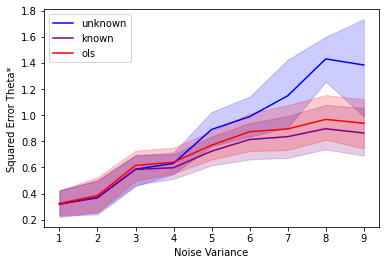

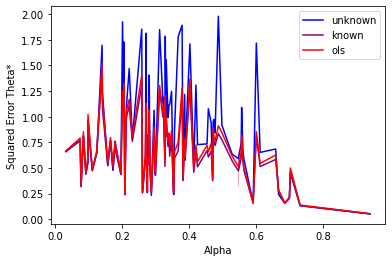

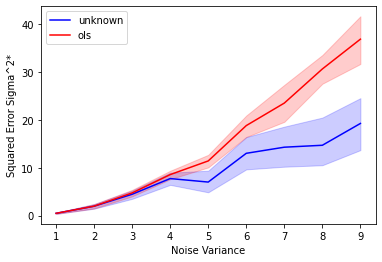

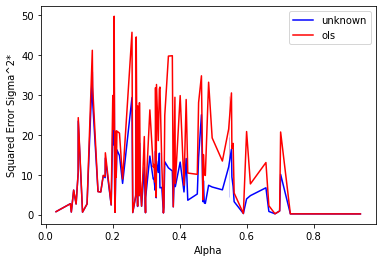

In [37]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=results, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=results, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Theta*')
plt.show()

# alpha vs param mse
sns.lineplot(data=results, x='alpha', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='alpha', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=results, x='alpha', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Alpha', ylabel='Squared Error Theta*')
plt.show()

# var vs var mse
sns.lineplot(data=results, x='var', y='unknown_var_mse', label='unknown', color='blue')
ax = sns.lineplot(data=results, x='var', y='ols_var_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Sigma^2*')
plt.show()

# alpha vs var mse
sns.lineplot(data=results, x='alpha', y='unknown_var_mse', label='unknown', color='blue')
ax = sns.lineplot(data=results, x='alpha', y='ols_var_mse', label='ols', color='red')
ax.set(xlabel='Alpha', ylabel='Squared Error Sigma^2*')
plt.show()

# Remove Best and Worst Trials

remove best and worst trials:


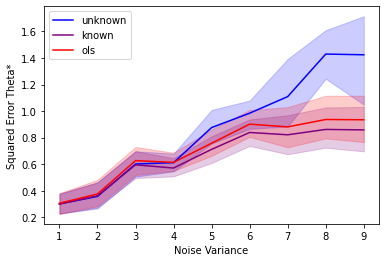

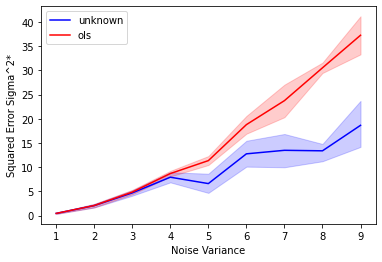

In [38]:
print("remove best and worst trials:")

# param mse wrt noise variance
sns.lineplot(data=results.drop(noise_lambda('unknown_param_mse')), x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results.drop(noise_lambda('known_param_mse')), x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=results.drop(noise_lambda('ols_param_mse')), x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Theta*')
plt.show()

# plot results for regression parameter MSE
sns.lineplot(data=results.drop(noise_lambda('unknown_var_mse')), x='var', y='unknown_var_mse', label='unknown', color='blue')
ax = sns.lineplot(data=results.drop(noise_lambda('ols_var_mse')), x='var', y='ols_var_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Sigma^2*')
plt.show()

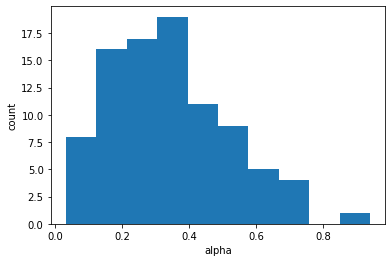

In [43]:
plt.hist(results['alpha'], bins=10)
plt.xlabel('alpha')
plt.ylabel('count')
plt.show()